In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py

**Load Dataset**

In [2]:
def load_dataset():
  train_dataset = h5py.File('train_catvnoncat.h5',"r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:])
  train_set_y_orig = np.array(train_dataset["train_set_y"][:])

  test_dataset = h5py.File('test_catvnoncat.h5',"r")
  test_set_x_orig = np.array(test_dataset['test_set_x'][:])
  test_set_y_orig = np.array(test_dataset['test_set_y'][:])

  classes = np.array(test_dataset["list_classes"][:])

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


(209, 64, 64, 3)

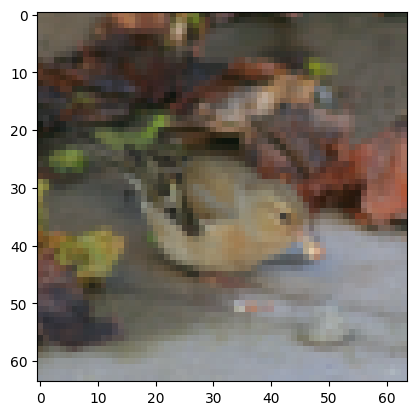

In [3]:
# Example of a picture
index = 39
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")
train_set_x_orig.shape

**Activation**

In [4]:
def ReLU(X):
  return np.maximum(0,X)

def ReLU_backward(dout,X):
  dx = dout.copy()
  dx[X <= 0] = 0
  return dx


**Linear Layer**

In [5]:
def xav_init(in_dim, out_dim):
  r = (6/(in_dim+out_dim))**(1/2)
  w = np.random.uniform(-r,r,size = (in_dim,out_dim))
  return w


In [6]:
class Activation:
  def forward(self, x):
    raise NotImplementedError

  def backward(self, dout):
    raise NotImplementedError

class Sigmoid(Activation):
  def forward(self, x):
    self.out = 1 / (1 + np.exp(-x))
    return self.out

  def backward(self, dout):
    return dout * self.out * (1 - self.out)

class ReLU(Activation):
  def forward(self, x):
    self.mask = x > 0
    return x * self.mask

  def backward(self, dout):
    return dout * self.mask

class Tanh(Activation):
  def forward(self, x):
    self.out = np.tanh(x)
    return self.out

  def backward(self, dout):
    return dout * (1 - self.out ** 2)


In [7]:
class Linear:
  def __init__(self, in_dim, out_dim):
    self.W = xav_init(in_dim,out_dim)

  def forward(self,x):
    self.x = x
    return x @ self.W
  def backward(self, dout, lr):
    dW = self.x.T @ dout
    dx = dout @ self.W.T
    self.W -= lr* dW
    return dx

In [8]:
class Network:
  def __init__(self, layers, activations):
    self.layers = layers
    self.activations = activations

  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    for layer, act in zip(self.layers, self.activations):
      x = act.forward(layer.forward(x))
    return x

  def backward(self, dout, lr):
    for layer, act in reversed(list(zip(self.layers, self.activations))):
      dout = act.backward(dout)
      dout = layer.backward(dout, lr)


**Convolution Layer**

In [9]:
def convolve_ch_first(image, kernel_list):
  """
  image: (C, H, W)
  kernel_list: list of kernels, each (C, K, K)
  """
  C, H, W = image.shape
  _, K, _ = kernel_list[0].shape

  outputs = []

  for kernel in kernel_list:
    out_h = H - K + 1
    out_w = W - K + 1
    out = np.zeros((out_h, out_w))

    for i in range(out_h):
      for j in range(out_w):
        patch = image[:, i:i+K, j:j+K]   # (C, K, K)
        out[i, j] = np.sum(patch * kernel)

    outputs.append(out)

  return np.array(outputs)


In [10]:
class Conv2D:
  def __init__(self, in_channels, num_filters, kernel_size):
    self.kernels = [
      np.random.randn(in_channels, kernel_size, kernel_size) * 0.01
      for _ in range(num_filters)
    ]
    self.kernel_size = kernel_size

  def forward(self, x):
    self.x = x
    self.out = convolve_ch_first(x, self.kernels)
    return self.out

  def backward(self, dout, lr=1e-2):
    """
    dout: (num_filters, out_h, out_w)
    """
    C, H, W = self.x.shape
    K = self.kernel_size
    F, out_h, out_w = dout.shape

    # gradients
    dx = np.zeros_like(self.x)
    dW = [np.zeros_like(k) for k in self.kernels]

    for f in range(F):
      kernel = self.kernels[f]

      for i in range(out_h):
        for j in range(out_w):
          patch = self.x[:, i:i+K, j:j+K]

          # kernel gradient
          dW[f] += patch * dout[f, i, j]

          # input gradient
          dx[:, i:i+K, j:j+K] += kernel * dout[f, i, j]

    # update kernels
    for f in range(F):
        self.kernels[f] -= lr * dW[f]

    return dx


In [11]:
class AvgPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        C, H, W = x.shape
        ph = pw = self.pool_size
        sh = sw = self.stride

        out_h = (H - ph) // sh + 1
        out_w = (W - pw) // sw + 1

        out = np.zeros((C, out_h, out_w))

        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h = i * sh
                    w = j * sw
                    patch = x[c, h:h+ph, w:w+pw]
                    out[c, i, j] = np.mean(patch)

        return out
    def __call__(self,x):
        return self.forward(x)
    
    def backward(self, dout, lr):
      C, H, W = self.x.shape
      ph = pw = self.pool_size
      sh = sw = self.stride

      dx = np.zeros_like(self.x)

      for c in range(C):
          for i in range(dout.shape[1]):
              for j in range(dout.shape[2]):
                  h = i * sh
                  w = j * sw
                  dx[c, h:h+ph, w:w+pw] += dout[c, i, j] / (ph * pw)

      return dx

class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, x):
        """
        x: (C, H, W)
        """
        C, H, W = x.shape
        ph, pw = self.pool_size, self.pool_size
        sh, sw = self.stride, self.stride

        out_h = (H - ph) // sh + 1
        out_w = (W - pw) // sw + 1

        out = np.zeros((C, out_h, out_w))
        self.mask = np.zeros_like(x)

        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * sh
                    w_start = j * sw
                    patch = x[c, h_start:h_start+ph, w_start:w_start+pw]

                    max_val = np.max(patch)
                    out[c, i, j] = max_val

                    # save mask for backward
                    idx = np.argmax(patch)
                    r, c2 = np.unravel_index(idx, patch.shape)
                    self.mask[c, h_start+r, w_start+c2] = 1

        return out
    
    def __call__(self,x):
        return self.forward(x)
    
    def backward(self, dout, lr):
      dx = self.mask * dout.repeat(self.pool_size, axis=1)\
                            .repeat(self.pool_size, axis=2)
      return dx


**Model**

In [12]:
class conv_model:
  def __init__(self, operations, activations):
    self.operations = operations
    self.activations = activations

  def __call__(self,x):
    return self.forward(x)
  
  def forward(self, x):
    for operation, act in zip(self.operations,self.activations):
      x = act.forward((operation(x)))
    return x
  
  def backward(self,dout, lr):
    for operation, act in reversed(list(zip(self.operations, self.activations))):
      dout = act.backward(dout)
      dout = operation.backward(dout, lr)


In [ ]:
learning_rate = 0.01
